In [1]:
import pandas as pd
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import os
from scipy import stats
import seaborn as sns

# Utils

## Data Processing

In [20]:
def process(path): 
# Return transpose array of the csv file given
    if 'div' not in path and 'subs' not in path:
        return []
    else:
        print(path)
    df = pd.read_csv(path,header = None)
    Z = np.array(df)
    return Z

In [21]:
def shapiro_test(data):
# Test the given data whether is normal distributed or not
    try:
        shapiro_test = stats.shapiro(data)
    except:
        #print("Shapiro test fails")
        return
    if shapiro_test.pvalue<0.01:
        #print(f"Reject: p-value {shapiro_test.pvalue}")
        return False # Reject H0:data is normal distributed
    else:
        return True # Cannot reject H0: data may be normal distributed

In [22]:
def find_threshold(Z):
# Find a suitable threshold for data given to splitted into 2 normal distributed groups
    bins = [(np.max(Z)-np.min(Z))/2+np.min(Z)]
    return bins
    bins = []
    step = (np.max(Z)-np.min(Z))/1000
    for i in np.arange(np.min(Z)+step,np.max(Z),step):
        z_dig = np.digitize(Z,[i])
        D = (1-z_dig)*Z
        class1 = (z_dig*Z).flatten()
        class2 = ((1-z_dig)*Z).flatten()
        class1 = class1[class1 != 0]
        class2 = class2[class2 != 0]
        if shapiro_test(class1) and shapiro_test(class2):
            bins.append(i)
    return bins

In [23]:
# Transform value map into dataframe with column: [value, X-coordinate, Y-coordinate]
def transform(Z):
    values = Z.flatten()
    
    x_coor = []
    y_coor = []
    # x-coordinates
    for i in range(len(Z)):
        x_coor.append(np.arange(len(Z[0])))
    for i in range(len(Z)):
        y_coor.append(i*np.ones(len(Z[0])))
    df = {'value':values,'x':np.array(x_coor).flatten(),'y':np.array(y_coor).flatten().astype(int)}
    df = pd.DataFrame(df)
    return df

## Plot Function

In [40]:
def plot_colormap(data,title = "AUT and QUARTZ",path = ""):
    """
    Helper function to plot data with associated colormap.
    """
   # fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
    #                        constrained_layout=True, squeeze=False)
    figure, axes = plt.subplots(figsize=(data.shape[0]/5,data.shape[1]/5))
    psm = axes.pcolormesh(data, cmap='rainbow',rasterized=True)
    figure.colorbar(psm, ax=axes)
    axes.invert_yaxis()
    if abs(data.shape[1]-data.shape[0])<=1:
        print(data.shape[1],data.shape[0])
        axes.set_aspect('equal', adjustable='box')
    plt.title(title)
    #plt.savefig(path+" "+title)
    plt.show()

In [25]:
def plot_2stat(Z,z_dig):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(Z.shape[1]/2,Z.shape[0]/5))
    psm = ax1.pcolormesh(z_dig, cmap='cool',rasterized=True)
    fig.colorbar(psm, ax=ax1)
    ax1.set_title("After process")
    
    
    class1 = (z_dig*Z).flatten()
    class2 = ((1-z_dig)*Z).flatten()
    class1 = class1[class1 != 0]
    class2 = class2[class2 != 0]
    mean1 = np.mean(class1)
    std1 = np.std(class1)
    mean2 = np.mean(class2)
    std2 = np.std(class2)
    print(len(class1))
    ax2.hist((class1,class2),bins=100,label = ("{:.3f} +- {:.3f}".format(mean1,std1),"{:.3f} +- {:.3f}".format(mean2,std2)),color = ('aqua','magenta'))
    ax2.legend(prop={'size': 30})

    plt.show()

In [26]:
def plot_labels(Z,label,dim1 = 49,dim2 = 50):
    # Reshape into dim1*dim2
    label = label.reshape(dim1,dim2)

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 7))
    sns.heatmap(Z,ax=ax1)
    sns.heatmap(label,ax = ax2)
    plt.show()
    #p = sns.scatterplot(data=Zt['value'], x=Zt['x'], y=Zt['y'], hue=clf.predict(Zt), legend="full", palette="deep")
    #sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
    #plt.show()

In [27]:
def plot_3d(Z,ele_deg=60,azi_deg=35):
    X = np.linspace(0, Z.shape[1]-1, Z.shape[1])
    Y = np.linspace(0, Z.shape[0]-1, Z.shape[0])
    
    fig = plt.figure(figsize = (10,20))
    for i in range(2):
        ax = fig.add_subplot(1,2,i+1,projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(ele_deg, azi_deg)
        ax.invert_xaxis()
        if i==0:
            ax.contour3D(X, Y, Z,50, cmap='rainbow')
        if i==1:
            Zt = transform(Z)
            ax.scatter(Zt['x'], Zt['y'],Zt['value'], c=Z, cmap='rainbow')
    plt.show()

In [28]:
def plot_3d_scatter(Z,ele_deg = 60,azi_deg = 35):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    X = np.linspace(0, 48, 49)
    Y = np.linspace(0, 59, 50)
    ax.scatter(X,Y, Z, cmap='rainbow',linewidth = 0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(ele_deg, azi_deg);
    plt.show()

# Main

In [29]:
# Find all the files
data_dir = "../data/221115_review/"
lst=os.listdir(data_dir)
files = []
for l in lst:
    if l[0] != '.':
        f_lst = os.listdir(data_dir+l)
        for f in f_lst:
            if '.png' not in f:
                files.append(data_dir+l+'/'+f)

In [30]:
# Find a threshold value to divide data into 2 normal distribution sets
# Fail
'''
for f in files:
    Z = process(f)
    if len(Z)!=0:
        bins = find_threshold(Z)
        if len(bins) == 0:
            print(f"Fail to find a threshold value for {f}")
        else:
            for b in bins:
                print(f"Drawing the result of {f} with threshold {b}")
                z_dig = np.digitize(Z,[b])
                plot_2stat(Z,z_dig)
'''

'\nfor f in files:\n    Z = process(f)\n    if len(Z)!=0:\n        bins = find_threshold(Z)\n        if len(bins) == 0:\n            print(f"Fail to find a threshold value for {f}")\n        else:\n            for b in bins:\n                print(f"Drawing the result of {f} with threshold {b}")\n                z_dig = np.digitize(Z,[b])\n                plot_2stat(Z,z_dig)\n'

# Unsupervised Machine Learning Method

In [31]:
from sklearn.cluster import KMeans

Z = process(files[5])
Zt = transform(Z)
# Create a k-means clustering model with 3 clusters
kmeans = KMeans(n_clusters=30)

# Fit the model to the data
kmeans.fit(Zt)

# Predict the cluster labels for each data point
labels = kmeans.predict(Zt)

# View the cluster labels for each data point
print(labels)

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_div-pqty=25.csv
[ 0  0  0 ... 17 17 17]


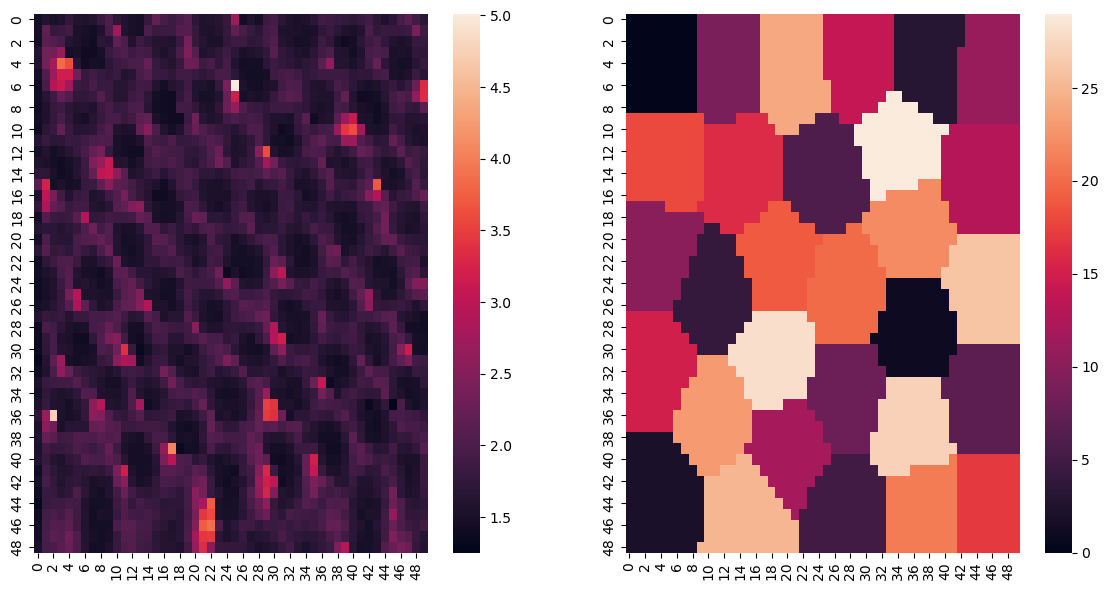

In [32]:
plot_labels(Z,labels)

In [33]:
from sklearn.svm import OneClassSVM
Z = process(files[5])
Zt = transform(Z)

clf = OneClassSVM(kernel='poly',gamma='auto').fit(Zt)
np.unique(clf.predict(Zt))

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_div-pqty=25.csv


array([-1,  1], dtype=int64)

C:\Users\caleb\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


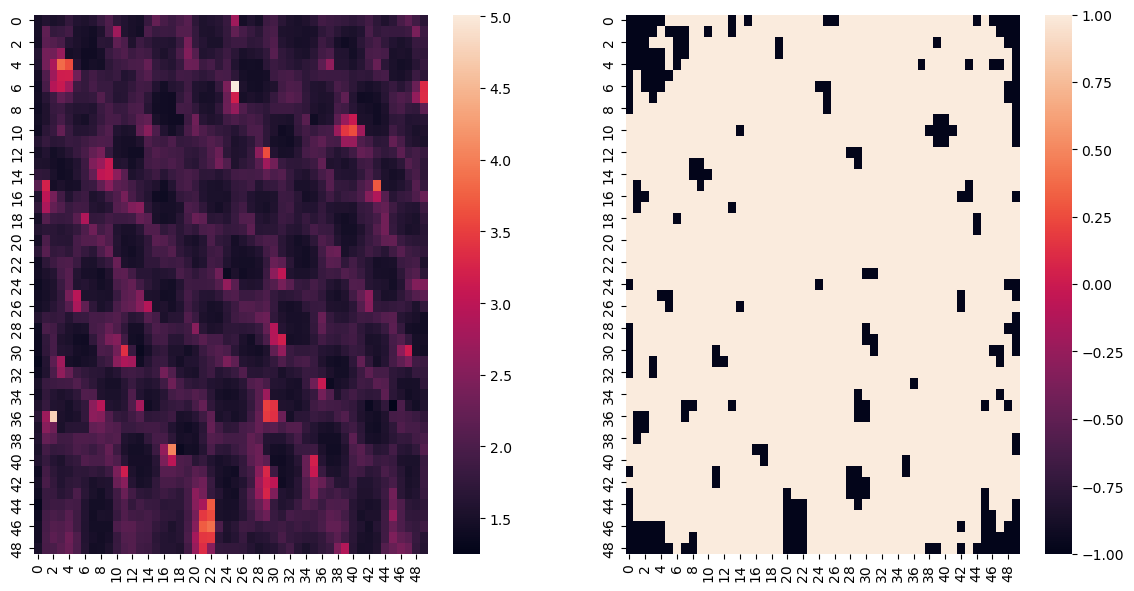

In [34]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination = 0.1,random_state=35).fit(Zt)
np.unique(clf.predict(Zt))
plot_labels(Z,clf.predict(Zt))

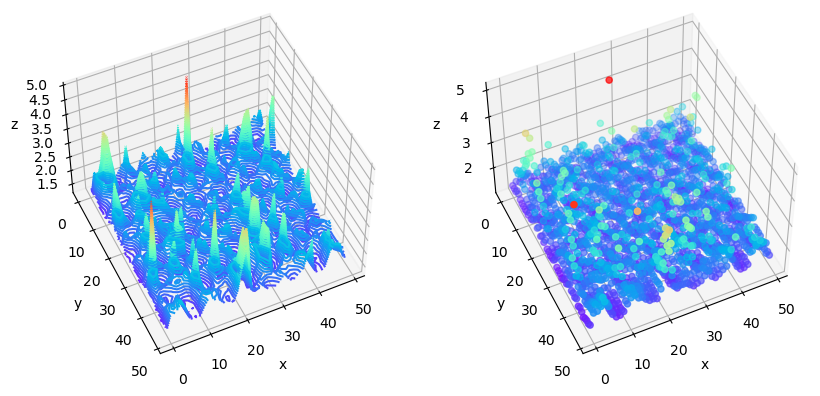

In [35]:
plot_3d(Z,ele_deg=50,azi_deg = 65)

50 49


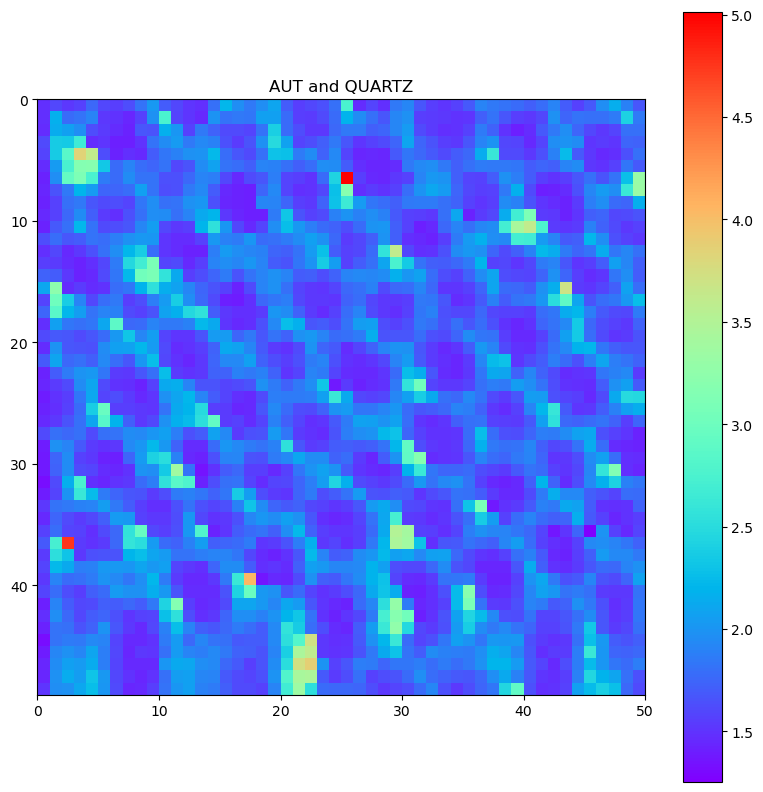

In [41]:
plot_colormap(Z)

49 48


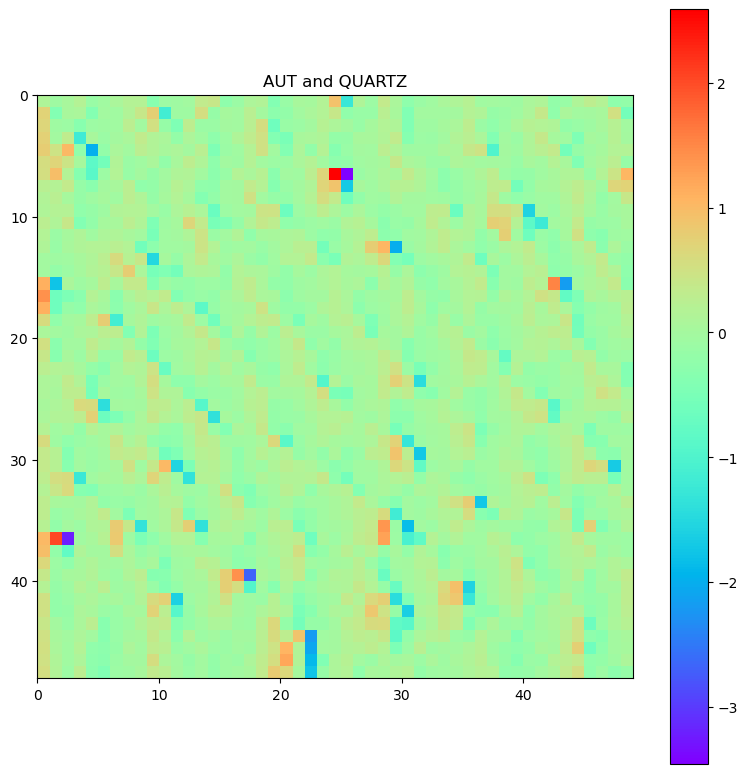

In [49]:
# x-difference
dx = np.zeros((Z.shape[0]-1,Z.shape[1]-1))
for i in range(dx.shape[0]):
    for j in range(dx.shape[1]):
        dx[i][j] = Z[i][j+1]-Z[i][j]
plot_colormap(dx)

49 48


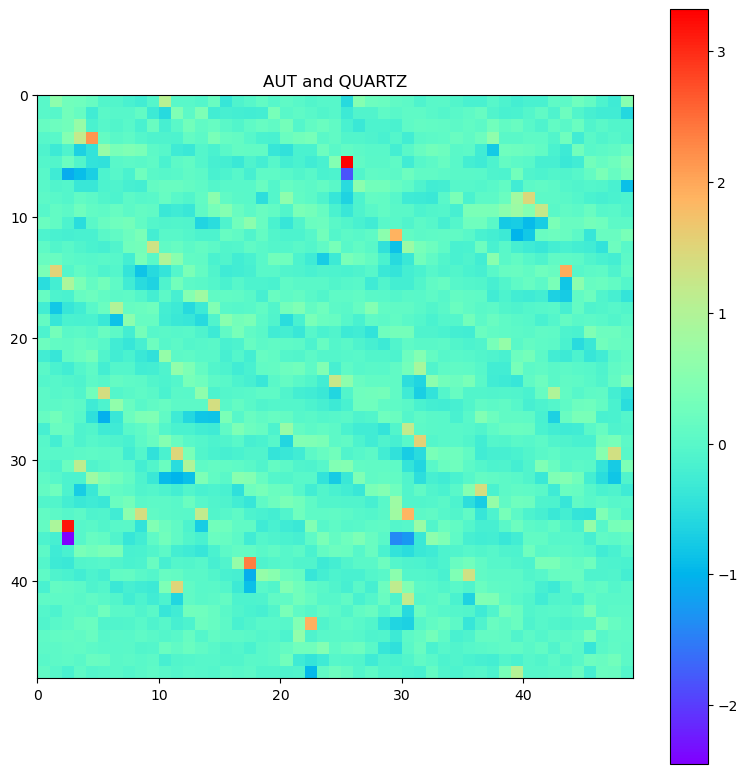

In [50]:
# y-difference
dy = np.zeros((Z.shape[0]-1,Z.shape[1]-1))
for i in range(dy.shape[0]):
    for j in range(dy.shape[1]):
        dy[i][j] = Z[i+1][j]-Z[i][j]
plot_colormap(dy)

In [18]:
# Search for local minimum, then expand until gradient is zero
# DFS
# 1. Check gradient of each point, to x+- and y+-, should be positive
# 2. Check the gradient not = 0
# 3. If gradient not = 0, active the node, continue search (Queue)

def fourGradCheck(Z,x,y,direction = None):
    if x>0:
        if Z[x-1][y]-Z[x][y]<0 and direction != "right":
            return False
    if x<Z.shape[0]-1:
        if Z[x+1][y]-Z[x][y]<0 and direction != "left":
            return False
    if y>0:
        if Z[x][y-1]-Z[x][y]<0 and direction != "down":
            return False
    if y<Z.shape[1]-1:
        if Z[x][y+1]-Z[x][y]<0 and direction != "up":
            return False
    return True

def dfs_point(x,y,direction = "None"):
    if (x,y) in act:
        return
    else:
        if fourGradCheck(Z,x,y,direction = direction):
            if direction != 'right':
                dfs_point(x-1)

q = []
act = [] # Active Point Found, (Tuple List)


0 8
0 13
0 23
0 27
1 1
1 3
1 5
1 11
1 17
1 20
1 25
1 28
1 30
1 33
1 36
1 38
1 42
2 7
2 9
2 16
2 21
2 45
2 47
3 4
3 10
3 12
3 19
3 25
3 27
3 31
3 43
4 0
4 5
4 16
4 20
4 23
4 36
4 45
5 2
5 7
5 11
5 14
5 18
5 27
5 29
5 32
5 38
5 41
5 43
5 46
6 20
6 35
6 40
7 3
7 5
7 12
7 14
7 19
7 26
7 28
7 36
7 41
8 0
8 7
8 9
8 18
8 29
8 35
8 37
8 45
8 47
9 3
9 11
9 19
9 21
9 27
9 30
9 34
9 36
9 38
9 40
10 1
10 4
10 16
10 22
10 26
10 28
10 41
11 0
11 12
11 17
11 25
11 29
11 35
11 37
11 44
12 3
12 16
12 21
12 23
12 31
12 34
12 47
13 0
13 5
13 7
13 12
13 17
13 25
13 35
13 38
13 40
13 43
14 1
14 9
14 20
14 23
14 32
14 44
14 48
15 10
15 13
15 19
15 21
15 36
15 42
16 0
16 2
16 8
16 16
16 27
16 32
16 41
16 44
16 47
17 4
17 6
17 13
17 19
17 30
17 34
17 39
17 42
18 0
18 7
18 11
18 15
18 21
18 27
18 33
19 2
19 5
19 18
19 26
19 29
19 32
19 34
19 38
19 40
19 42
19 46
20 0
20 3
20 10
20 14
20 27
21 1
21 7
21 9
21 16
21 18
21 25
21 32
21 43
22 4
22 10
22 12
22 14
22 19
22 22
22 29
22 31
22 36
22 39
22 44
22 47
23 3
2